<a href="https://colab.research.google.com/github/LucianoPer/VPC2/blob/main/8_Red_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Red Inception :**
La arquitectura de estas redes esta basada en realizar varias convoluciones con distintos tamanos de filtros con padding 'same' para que todas tengan las mismas dimensiones de altura y ancho y luego apilar los resultados. 


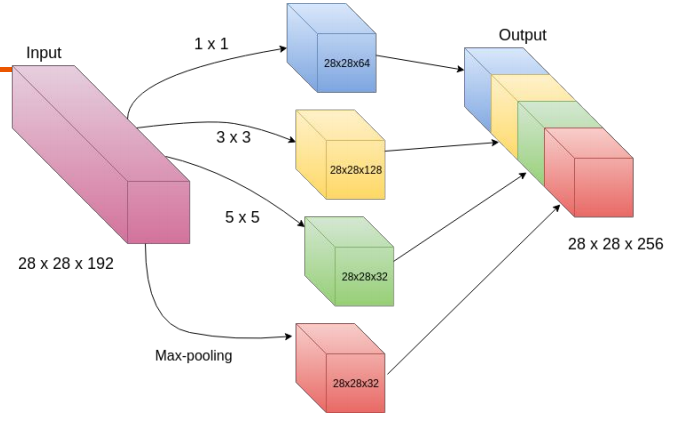

La cantidad de operaciones que debera realizar en cada etapa convolucional:
>$n_o=(5*5*192) * (28*28*32) = 120422400$

Para el caso de filtro de convolucion de 5x5 requiere 120 millones de operaciones.

Para solucionar este gran volumen de operaciones que se requieren realizar, se utilizan convoluciones 1x1

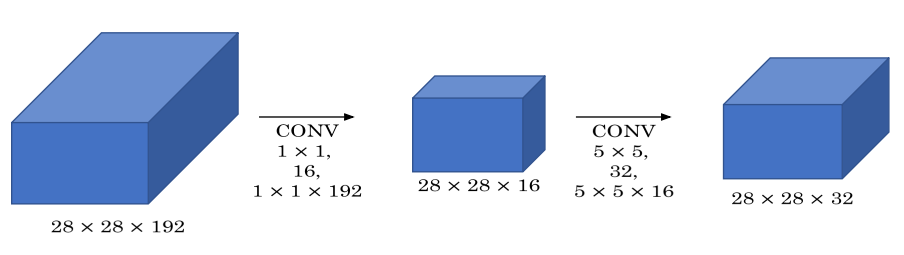

Lo que se hace es tomar una covolucion con filtro 1x1 y 16 canales, con lo que reducimos la imagen a una dimension de 28x28x16. La cantidad de calculos requeridos ahora es:

$n_o=(1*1*192)*(28*28*16)=2408448$


El volumen de salida es de 28x28x16, y por cada elemento de ese volumen de salida se realizo 1x1x192 operaciones. Luego para la segunda etapa tenemos:

$n_o=(28*28*32)*(5*5*16)=10035200$

Comparando con el esquema anterior, en este caso se requirio en total 12.4 millones de operaciones contra 120 millones del caso anterior.

Por lo tanto el esquema queda ahora:

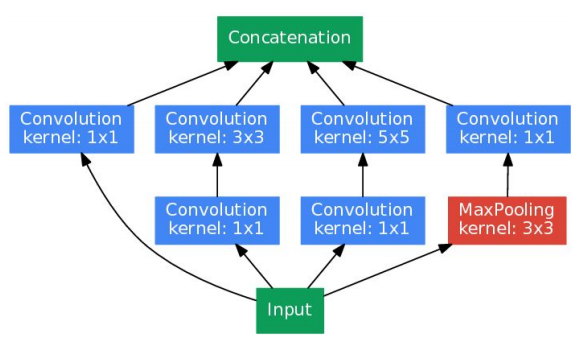

Como el Max-pooling mantiene la cantidad de canales original necesitamos agregar una convolucion  que nos de una salida con una cantidad de canales inferior a la original. 

Luego se concantena el bloque con otro bloque similar y asi sucesivamente, formando la arquitectura de la red como se ejemplifica a continuacion: 

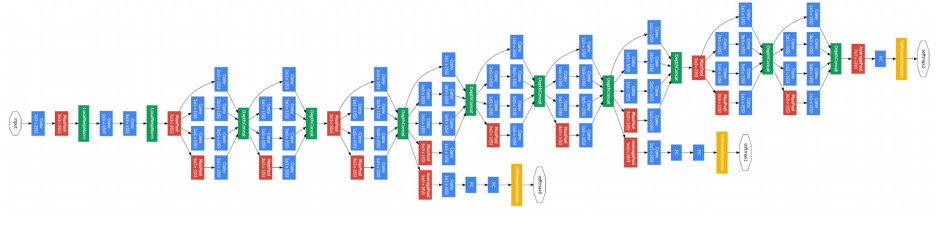

### Implementacion:

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras import backend
import numpy as np
import tensorflow as tf

In [ ]:
# función para crear un modulo inception sin optimización
def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenar los filtros, asume que los filtros están en la última dimensión
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

In [ ]:
# definir la entrada del modelo
visible = Input(shape=(256, 256, 3))
# agregar el modulo inception
layer = naive_inception_module(visible, 64, 128, 32)
# crear modelo
model = Model(inputs=visible, outputs=layer)
# resumen
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 2432        input_1[0][0]                    
_______________________________________________________________________________________

Creamos ahora el modelo con la convolucion de 1x1 antes de aplicar las otras convoluciones para reducir el numero de operaciones y optimizar la red.

In [ ]:
# función para crear un módulo inception usando convolución 1x1 para hacerlo más eficiente
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

In [ ]:
# definir el modelo
visible = Input(shape=(256, 256, 3))
# agregar primer bloque inception
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
# agregar segundo bloque inception
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)
# crear el modelo
model = Model(inputs=visible, outputs=layer)
# resumen del modelo
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 256, 256, 96) 384         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 16) 64          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 3)  0           input_2[0][0]                    
_______________________________________________________________________________________